**수면 단계 분류 작업은 크게 3가지로 나누어 진행한다.**

1. Wake VS Sleep (각성 탐지)

2. 2-class classification
    * Wake VS Light(N1+N2)
    * Wake VS DEEP(N3)
    * Wake VS REM
    
3. 4-class classification

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
import re
import pickle

from IPython.core.display import display, HTML
from tqdm.auto import tqdm


plt.style.use('seaborn')
%matplotlib inline
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, confusion_matrix

In [9]:
# preprocessed data load

import pickle
with open("sleep_df.pickle","rb") as fr:
    sleep_df = pickle.load(fr)


# Wake VS Sleep

**수면과 각성 분류가 전반적으로 0.9 이상의 f1-score로 잘 분류되는 것을 확인할 수 있음**

In [7]:
# 모든 Baseline 분류 모델을 사용해서 cv=5로 f1-score를 사용해 scoring
def get_predict(X_train, X_test, y_train, y_test, scoring='f1'):
    res = [] # 모델별 f1-score 리스트
    model_list = [LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, SVC,ExtraTreesClassifier, 
                  RandomForestClassifier, XGBClassifier,  LGBMClassifier]

    for model in model_list:
        clf = model()
        score = np.mean(cross_val_score(clf, data, target, scoring=scoring, cv=5)) # 5-fold cv의 평균
        res.append(score)
        
    return res

In [14]:
wake_sleep = []

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i] # i번째 피험자의 전처리된 수면 데이터
    tmp_df = df.copy() # 데이터 유지를 위해 복사
    tmp_df['label'] = df['label'].replace([1, 2, 3, 5], 1) # Wake VS Sleep을 위해 수면 라벨을 모두 1로 치환
    data, target = tmp_df.drop('label', axis=1), tmp_df['label'] # data, target split
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42) # train, test set split
    wake_sleep.append(get_predict(X_train, X_test, y_train, y_test)) # 결과 저장
    
# 리스트를 넘파이 배열로 변환
wake_sleep = np.array(wake_sleep)

  0%|          | 0/16 [00:00<?, ?it/s]

In [23]:
# 결과 확인 함수
def get_result(df):
    # 사용한 분류 모델 이름
    model_name_list = ['Logistic', 'DecisionTree', 'KNN', 'SVC','ExtraTree', 'RandomForest', 'XGB',  'LGBM']

    for i in range(len(sleep_df)):
        print(f'== {i}번째 피험자 수면 분류 f1-score ==')
        for name, score in zip(model_name_list, df[i]):                                         
            print(f'{name} : {score:.5f}', end=' , ')
        print()
        print()
    
    # 각 열별로 평균 계산 (분류 모델별 평균 정확도 확인)
    df_avg = np.mean(df, axis=0)
    
    print(f'== 모델별 평균 수면 분류 f1-score ==')    
    for name, score in zip(model_name_list, df_avg):                                         
        print(f'{name} : {score:.5f}', end=' , ')
        
get_result(wake_sleep)

== 0번째 피험자 수면 분류 f1-score ==
Logistic : 0.94942 , DecisionTree : 0.88060 , KNN : 0.94320 , SVC : 0.95583 , ExtraTree : 0.93443 , RandomForest : 0.92599 , XGB : 0.92939 , LGBM : 0.93574 , 

== 1번째 피험자 수면 분류 f1-score ==
Logistic : 0.92819 , DecisionTree : 0.81686 , KNN : 0.90794 , SVC : 0.92394 , ExtraTree : 0.92040 , RandomForest : 0.89047 , XGB : 0.88686 , LGBM : 0.89431 , 

== 2번째 피험자 수면 분류 f1-score ==
Logistic : 0.88491 , DecisionTree : 0.75711 , KNN : 0.84786 , SVC : 0.89646 , ExtraTree : 0.84613 , RandomForest : 0.84889 , XGB : 0.83481 , LGBM : 0.82960 , 

== 3번째 피험자 수면 분류 f1-score ==
Logistic : 0.92321 , DecisionTree : 0.87997 , KNN : 0.92511 , SVC : 0.92778 , ExtraTree : 0.92636 , RandomForest : 0.90677 , XGB : 0.90853 , LGBM : 0.90710 , 

== 4번째 피험자 수면 분류 f1-score ==
Logistic : 0.97931 , DecisionTree : 0.95757 , KNN : 0.97881 , SVC : 0.97934 , ExtraTree : 0.97714 , RandomForest : 0.97216 , XGB : 0.97417 , LGBM : 0.97432 , 

== 5번째 피험자 수면 분류 f1-score ==
Logistic : 0.97686 , Decis

# 2-class Classification

* Wake VS Light (N1+N2)
* Wake VS DEEP (N3)
* Wake VS REM

**Wake와 Light 분류가 전반적으로 0.85 이상의 f1-score로 분류되는 것을 확인할 수 있음**

**Wake와 Deep 분류가 전반적으로 약 0.8의 f1-score로 분류되는 것을 확인할 수 있음**

**Wake와 REM 분류가 전반적으로 약 0.8의 f1-score로 분류되는 것을 확인할 수 있음**

## Wake VS Light

In [24]:
wake_light = []

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 수면 라벨링이 0, 1, 2인 데이터만 추출
    tmp_df = df[(df['label'] ==  0) | (df['label'] ==  1) | ((df['label'] ==  2))]
    
    # N1+N2를 Light로 표현, => 수면 라벨링 2를 1로 치환
    tmp_df['label'].replace(2, 1, inplace=True)
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    wake_light.append(get_predict(X_train, X_test, y_train, y_test)) # 결과 저장
    
# 넘파이 배열로 변환
wake_light = np.array(wake_light)

  0%|          | 0/16 [00:00<?, ?it/s]

In [25]:
get_result(wake_light)

== 0번째 피험자 수면 분류 f1-score ==
Logistic : 0.93081 , DecisionTree : 0.87936 , KNN : 0.91190 , SVC : 0.93911 , ExtraTree : 0.90114 , RandomForest : 0.89766 , XGB : 0.90646 , LGBM : 0.90897 , 

== 1번째 피험자 수면 분류 f1-score ==
Logistic : 0.89086 , DecisionTree : 0.80709 , KNN : 0.86552 , SVC : 0.89311 , ExtraTree : 0.88058 , RandomForest : 0.86169 , XGB : 0.85803 , LGBM : 0.86004 , 

== 2번째 피험자 수면 분류 f1-score ==
Logistic : 0.84046 , DecisionTree : 0.72605 , KNN : 0.75910 , SVC : 0.83958 , ExtraTree : 0.76310 , RandomForest : 0.76520 , XGB : 0.75924 , LGBM : 0.76636 , 

== 3번째 피험자 수면 분류 f1-score ==
Logistic : 0.88481 , DecisionTree : 0.83734 , KNN : 0.90166 , SVC : 0.88938 , ExtraTree : 0.86074 , RandomForest : 0.85053 , XGB : 0.83866 , LGBM : 0.83978 , 

== 4번째 피험자 수면 분류 f1-score ==
Logistic : 0.96857 , DecisionTree : 0.96156 , KNN : 0.96679 , SVC : 0.96700 , ExtraTree : 0.96926 , RandomForest : 0.97156 , XGB : 0.96561 , LGBM : 0.96757 , 

== 5번째 피험자 수면 분류 f1-score ==
Logistic : 0.96259 , Decis

## Wake VS Deep

In [26]:
wake_deep = []

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 수면 라벨링이 0, 3인 데이터만 추출
    tmp_df = df[(df['label'] ==  0) | (df['label'] ==  3)]
    
    # 수면 라벨링 3를 1로 치환
    tmp_df['label'].replace(3, 1, inplace=True)
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    wake_deep.append(get_predict(X_train, X_test, y_train, y_test))
    
# 넘파이 배열로 변환
wake_deep = np.array(wake_deep)

  0%|          | 0/16 [00:00<?, ?it/s]

In [27]:
get_result(wake_deep)

== 0번째 피험자 수면 분류 f1-score ==
Logistic : 0.43000 , DecisionTree : 0.67500 , KNN : 0.52254 , SVC : 0.08000 , ExtraTree : 0.70540 , RandomForest : 0.76056 , XGB : 0.73278 , LGBM : 0.82222 , 

== 1번째 피험자 수면 분류 f1-score ==
Logistic : 0.81876 , DecisionTree : 0.40636 , KNN : 0.80925 , SVC : 0.80539 , ExtraTree : 0.59543 , RandomForest : 0.45461 , XGB : 0.52515 , LGBM : 0.50772 , 

== 2번째 피험자 수면 분류 f1-score ==
Logistic : 0.75310 , DecisionTree : 0.74708 , KNN : 0.68040 , SVC : 0.09600 , ExtraTree : 0.80184 , RandomForest : 0.74689 , XGB : 0.77826 , LGBM : 0.77156 , 

== 3번째 피험자 수면 분류 f1-score ==
Logistic : 0.89232 , DecisionTree : 0.95128 , KNN : 0.87542 , SVC : 0.88758 , ExtraTree : 0.95476 , RandomForest : 0.96137 , XGB : 0.95512 , LGBM : 0.96112 , 

== 4번째 피험자 수면 분류 f1-score ==
Logistic : 0.88100 , DecisionTree : 0.89624 , KNN : 0.88291 , SVC : 0.87294 , ExtraTree : 0.90766 , RandomForest : 0.93338 , XGB : 0.89572 , LGBM : 0.90453 , 

== 5번째 피험자 수면 분류 f1-score ==
Logistic : 0.92790 , Decis

## Wake VS REM

In [28]:
wake_rem = []

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 수면 라벨링이 0, 5인 데이터만 추출
    tmp_df = df[(df['label'] ==  0) | (df['label'] ==  5)]
    
    # 수면 라벨링 5를 1로 치환
    tmp_df['label'].replace(5, 1, inplace=True)
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    wake_rem.append(get_predict(X_train, X_test, y_train, y_test))

# 넘파이 배열로 변환
wake_rem = np.array(wake_rem)

  0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
get_result(wake_rem)

== 0번째 피험자 수면 분류 f1-score ==
Logistic : 0.85442 , DecisionTree : 0.78767 , KNN : 0.85954 , SVC : 0.85567 , ExtraTree : 0.84811 , RandomForest : 0.82349 , XGB : 0.84882 , LGBM : 0.84763 , 

== 1번째 피험자 수면 분류 f1-score ==
Logistic : 0.86929 , DecisionTree : 0.76581 , KNN : 0.85610 , SVC : 0.88032 , ExtraTree : 0.73962 , RandomForest : 0.72940 , XGB : 0.72490 , LGBM : 0.71633 , 

== 2번째 피험자 수면 분류 f1-score ==
Logistic : 0.71807 , DecisionTree : 0.68562 , KNN : 0.72425 , SVC : 0.73742 , ExtraTree : 0.73763 , RandomForest : 0.74131 , XGB : 0.68624 , LGBM : 0.69135 , 

== 3번째 피험자 수면 분류 f1-score ==
Logistic : 0.82124 , DecisionTree : 0.66084 , KNN : 0.82400 , SVC : 0.84611 , ExtraTree : 0.80611 , RandomForest : 0.67280 , XGB : 0.73213 , LGBM : 0.73260 , 

== 4번째 피험자 수면 분류 f1-score ==
Logistic : 0.91059 , DecisionTree : 0.86432 , KNN : 0.90116 , SVC : 0.91667 , ExtraTree : 0.92026 , RandomForest : 0.92635 , XGB : 0.91713 , LGBM : 0.90579 , 

== 5번째 피험자 수면 분류 f1-score ==
Logistic : 0.92629 , Decis

## Model Tuning based Feature Importance

모델 모두 비슷한 성능을 보이므로 특성 중요도를 확인할 수 있는 앙상블 모델 중 점수가 가장 높은 모델인 **Random Forest** 사용 

feature importance가 높은 순서대로 1개씩 잘라서 모델 성능 비교 (feature는 모두 24개)


**모든 분류 작업에서 feature importance를 가지고 개인에 맞는 feature를 선택하는 것이 점수가 더 높아짐**

### Wake VS Sleep

In [30]:
wake_sleep_feat_importance = [] # 각 피험자별 feature importance 순위 리스트

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    tmp_df = df.copy() # 원본 데이터 복사
    tmp_df['label'] = df['label'].replace([1, 2, 3, 5], 1) # 수면 라벨링을 모두 1로 치환
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    clf = RandomForestClassifier() # 랜덤 포레스트 모델 사용

    clf.fit(X_train, y_train)  # 모델 학습

    # 피처 중요도 얻기
    feature_importance = clf.feature_importances_
    
    # 시리즈로 변환 후 내림차순 정렬
    ft_series = pd.Series(feature_importance, index = X_train.columns).sort_values(ascending=False)
    
    # 리스트에 추가
    wake_sleep_feat_importance.append(ft_series)


  0%|          | 0/16 [00:00<?, ?it/s]

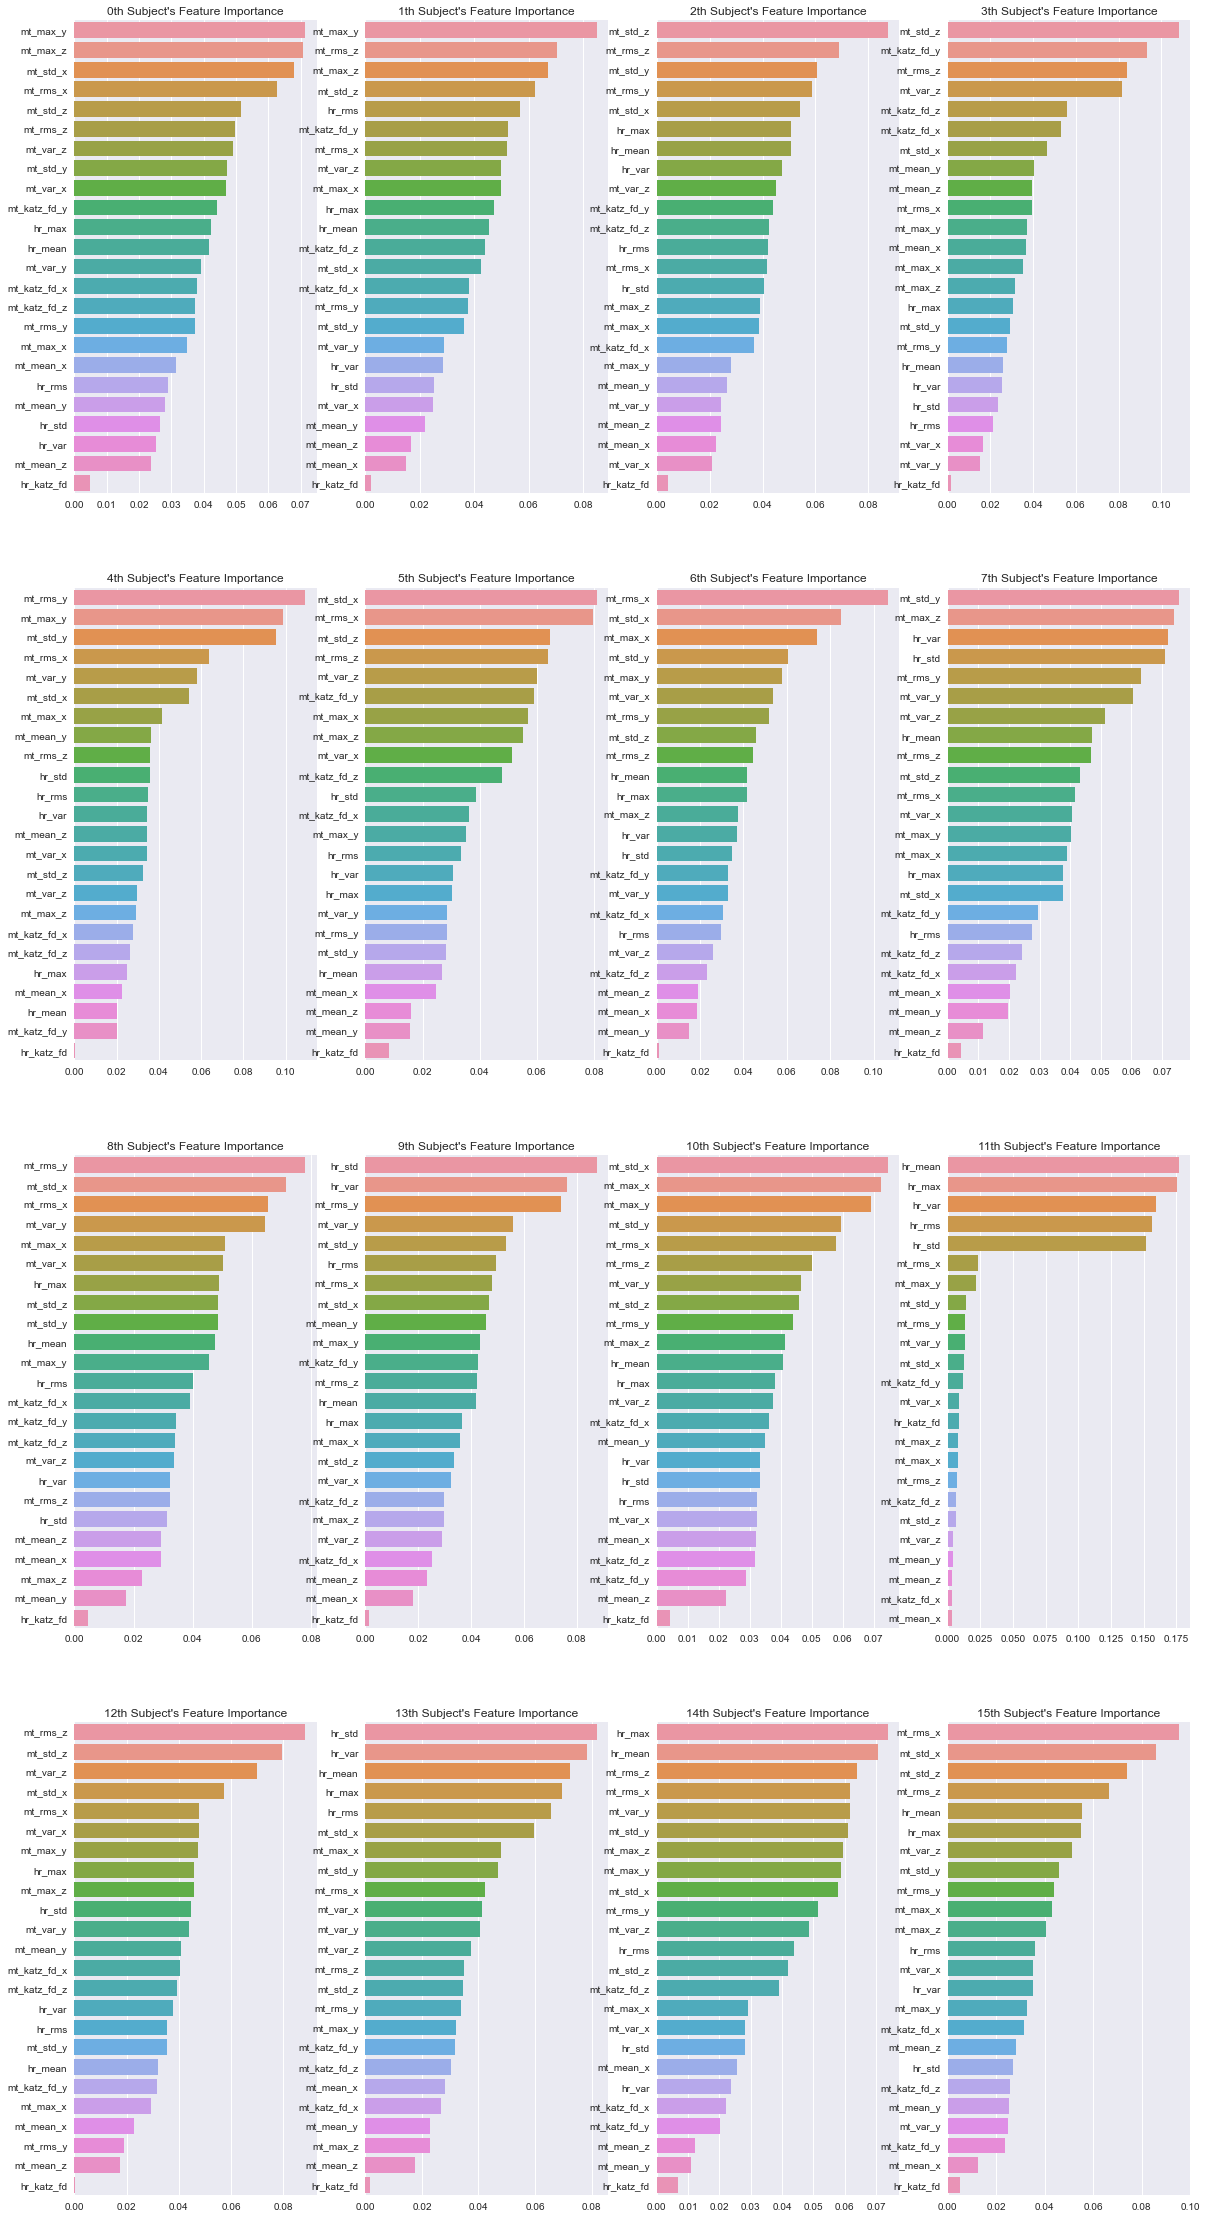

In [38]:
# feature importance 시각화 함수
def plot_ft_importance(df):
    f, ax = plt.subplots(4, 4, figsize=(20, 40))
    for i in range(4):
        for j in range(4):
            ax[i][j].set_title(f"{i*4+j}th Subject's Feature Importance")
            sns.barplot(x=df[i*4+j], y=df[i*4+j].index, ax=ax[i][j])
    plt.show()
        
plot_ft_importance(wake_sleep_feat_importance)

In [39]:
wake_sleep_res = [0] * 16 # 16명 피험자의 각성VS수면 분류 f1-score 리스트
wake_sleep_ft_cnt = [-1] * 16 # 16명 피험자의 피쳐 개수 리스트

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 피쳐 중요도 인덱스 추출
    ft_importance = wake_sleep_feat_importance[i].index
    
    for j in tqdm(range(len(ft_importance))):
        # feature importance 가 높은 순서대로 1개씩 더해가며 피쳐 추가 후 성능 확인
        col = ft_importance[:j+1]
        
        tmp_df = df[col]
        
        # 수면 라벨링을 모두 1로 치환
        tmp_df['label'] = df['label'].replace([1, 2, 3, 5], 1)
        
        data, target = tmp_df.drop('label', axis=1), tmp_df['label']
        
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
        clf = RandomForestClassifier()
        
        # 5-fold cv로 교차 검증 결과의 평균
        score = np.mean(cross_val_score(clf, data, target, scoring='f1', cv=5))
        
        # 현재 결과가 최댓값보다 크면 f1-score와 feature 개수 update
        if score > wake_sleep_res[i]:
            wake_sleep_res[i] = score
            wake_sleep_ft_cnt[i] = j+1

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [45]:
# 결과 출력 함수
def get_score_with_ft_cnt(result_df, ft_cnt_df):
    for i in range(len(result_df)):
        print(f'{i}th f1-score: {result_df[i]:.5f}, Feature Number: {ft_cnt_df[i]}')
        
get_score_with_ft_cnt(wake_sleep_res,wake_sleep_ft_cnt)

0th f1-score: 0.94770, Feature Number: 3
1th f1-score: 0.91398, Feature Number: 6
2th f1-score: 0.84734, Feature Number: 21
3th f1-score: 0.91056, Feature Number: 9
4th f1-score: 0.97809, Feature Number: 3
5th f1-score: 0.97944, Feature Number: 17
6th f1-score: 0.92035, Feature Number: 24
7th f1-score: 0.97501, Feature Number: 12
8th f1-score: 0.93272, Feature Number: 21
9th f1-score: 0.96462, Feature Number: 3
10th f1-score: 0.95779, Feature Number: 23
11th f1-score: 0.84597, Feature Number: 7
12th f1-score: 0.97551, Feature Number: 13
13th f1-score: 0.96724, Feature Number: 24
14th f1-score: 0.93674, Feature Number: 3
15th f1-score: 0.92301, Feature Number: 14


### Wake VS Light

In [46]:
wake_light_feat_importance = [] # 각 피험자별 feature importance 순위 리스트
 
for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 수면 라벨링이 0, 1, 2인 데이터만 추출
    tmp_df = df[(df['label'] ==  0) | (df['label'] ==  1) | ((df['label'] ==  2))]
    tmp_df['label'].replace(2, 1, inplace=True)
    
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    
    clf = RandomForestClassifier() # 랜덤 포레스트 모델 사용

    clf.fit(X_train, y_train) # 모델 학습

    # 피처 중요도 얻기
    feature_importance = clf.feature_importances_
    
    # 시리즈로 변환 후 내림차순 정렬
    ft_series = pd.Series(feature_importance, index = X_train.columns).sort_values(ascending=False)
    
    # 리스트에 추가
    wake_light_feat_importance.append(ft_series)


  0%|          | 0/16 [00:00<?, ?it/s]

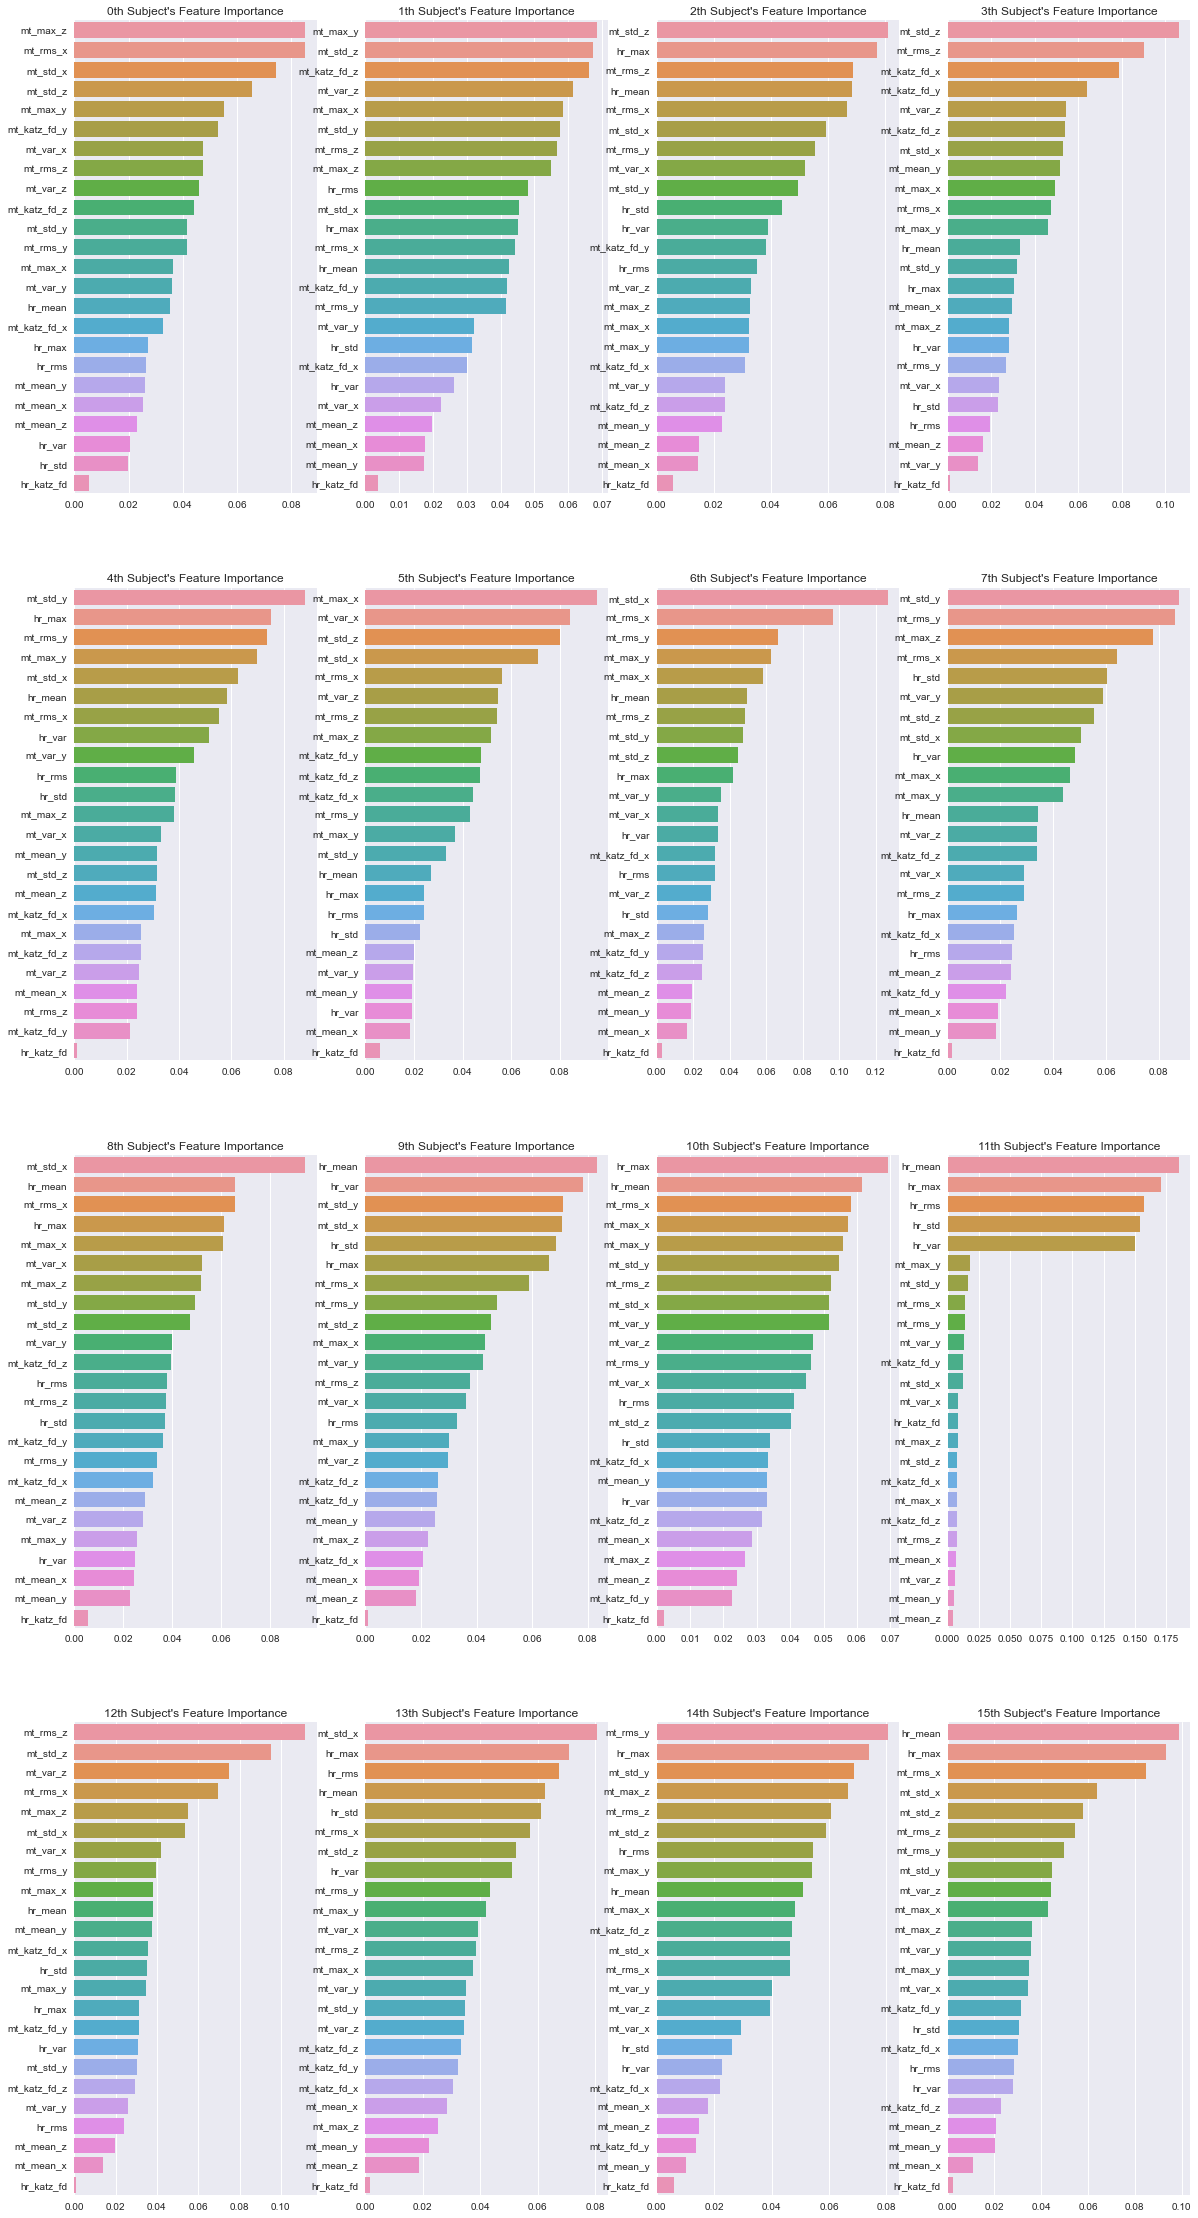

In [47]:
plot_ft_importance(wake_light_feat_importance)

In [48]:
wake_light_res = [0] * 16 # 16명 피험자의 Sleep VS Light 분류 f1-score 리스트
wake_light_ft_cnt = [-1] * 16 # 16명 피험자의 피쳐 개수 리스트

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 수면 라벨링이 0, 1, 2인 데이터만 추출
    df = df[(df['label'] ==  0) | (df['label'] ==  1) | ((df['label'] ==  2))]
    
    # 피쳐 중요도 인덱스 추출
    ft_importance = wake_light_feat_importance[i].index
    
    for j in tqdm(range(len(ft_importance))):
        # feature importance 가 높은 순서대로 1개씩 더해가며 피쳐 추가 후 성능 확인
        col = ft_importance[:j+1]
        
        tmp_df = df[col]
        
        # N2를 1로 치환
        tmp_df['label'] = df['label'].replace(2, 1)
        data, target = tmp_df.drop('label', axis=1), tmp_df['label']
        
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
        clf = RandomForestClassifier()
        
        # 5-fold cv로 교차 검증 결과의 평균
        score = np.mean(cross_val_score(clf, data, target, scoring='f1', cv=5))
        
        # 현재 결과가 최댓값보다 크면 f1-score와 feature 개수 update
        if score > wake_light_res[i]:
            wake_light_res[i] = score
            wake_light_ft_cnt[i] = j+1

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [53]:
get_score_with_ft_cnt(wake_light_res, wake_light_ft_cnt)

0th f1-score: 0.92751, Feature Number: 6
1th f1-score: 0.88106, Feature Number: 3
2th f1-score: 0.78746, Feature Number: 24
3th f1-score: 0.86119, Feature Number: 19
4th f1-score: 0.97244, Feature Number: 15
5th f1-score: 0.96305, Feature Number: 12
6th f1-score: 0.88187, Feature Number: 23
7th f1-score: 0.95381, Feature Number: 18
8th f1-score: 0.91119, Feature Number: 7
9th f1-score: 0.95464, Feature Number: 11
10th f1-score: 0.93227, Feature Number: 22
11th f1-score: 0.76099, Feature Number: 6
12th f1-score: 0.95810, Feature Number: 12
13th f1-score: 0.94239, Feature Number: 17
14th f1-score: 0.91834, Feature Number: 6
15th f1-score: 0.93682, Feature Number: 13


In [50]:
wake_deep_feat_importance = [] # 각 피험자별 feature importance 순위 리스트

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]

    # 수면 라벨링이 0, 3인 데이터만 추출
    tmp_df = df[(df['label'] ==  0) | (df['label'] ==  3)]
    tmp_df['label'].replace(3, 1, inplace=True)
    
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    
    clf = RandomForestClassifier() # 랜덤 포레스트 모델 사용
    clf.fit(X_train, y_train) # 모델 학습

    # 피처 중요도 얻기
    feature_importance = clf.feature_importances_
    
    # 시리즈로 변환 후 내림차순 정렬
    ft_series = pd.Series(feature_importance, index = X_train.columns).sort_values(ascending=False)
    
    # 리스트에 추가
    wake_deep_feat_importance.append(ft_series)


  0%|          | 0/16 [00:00<?, ?it/s]

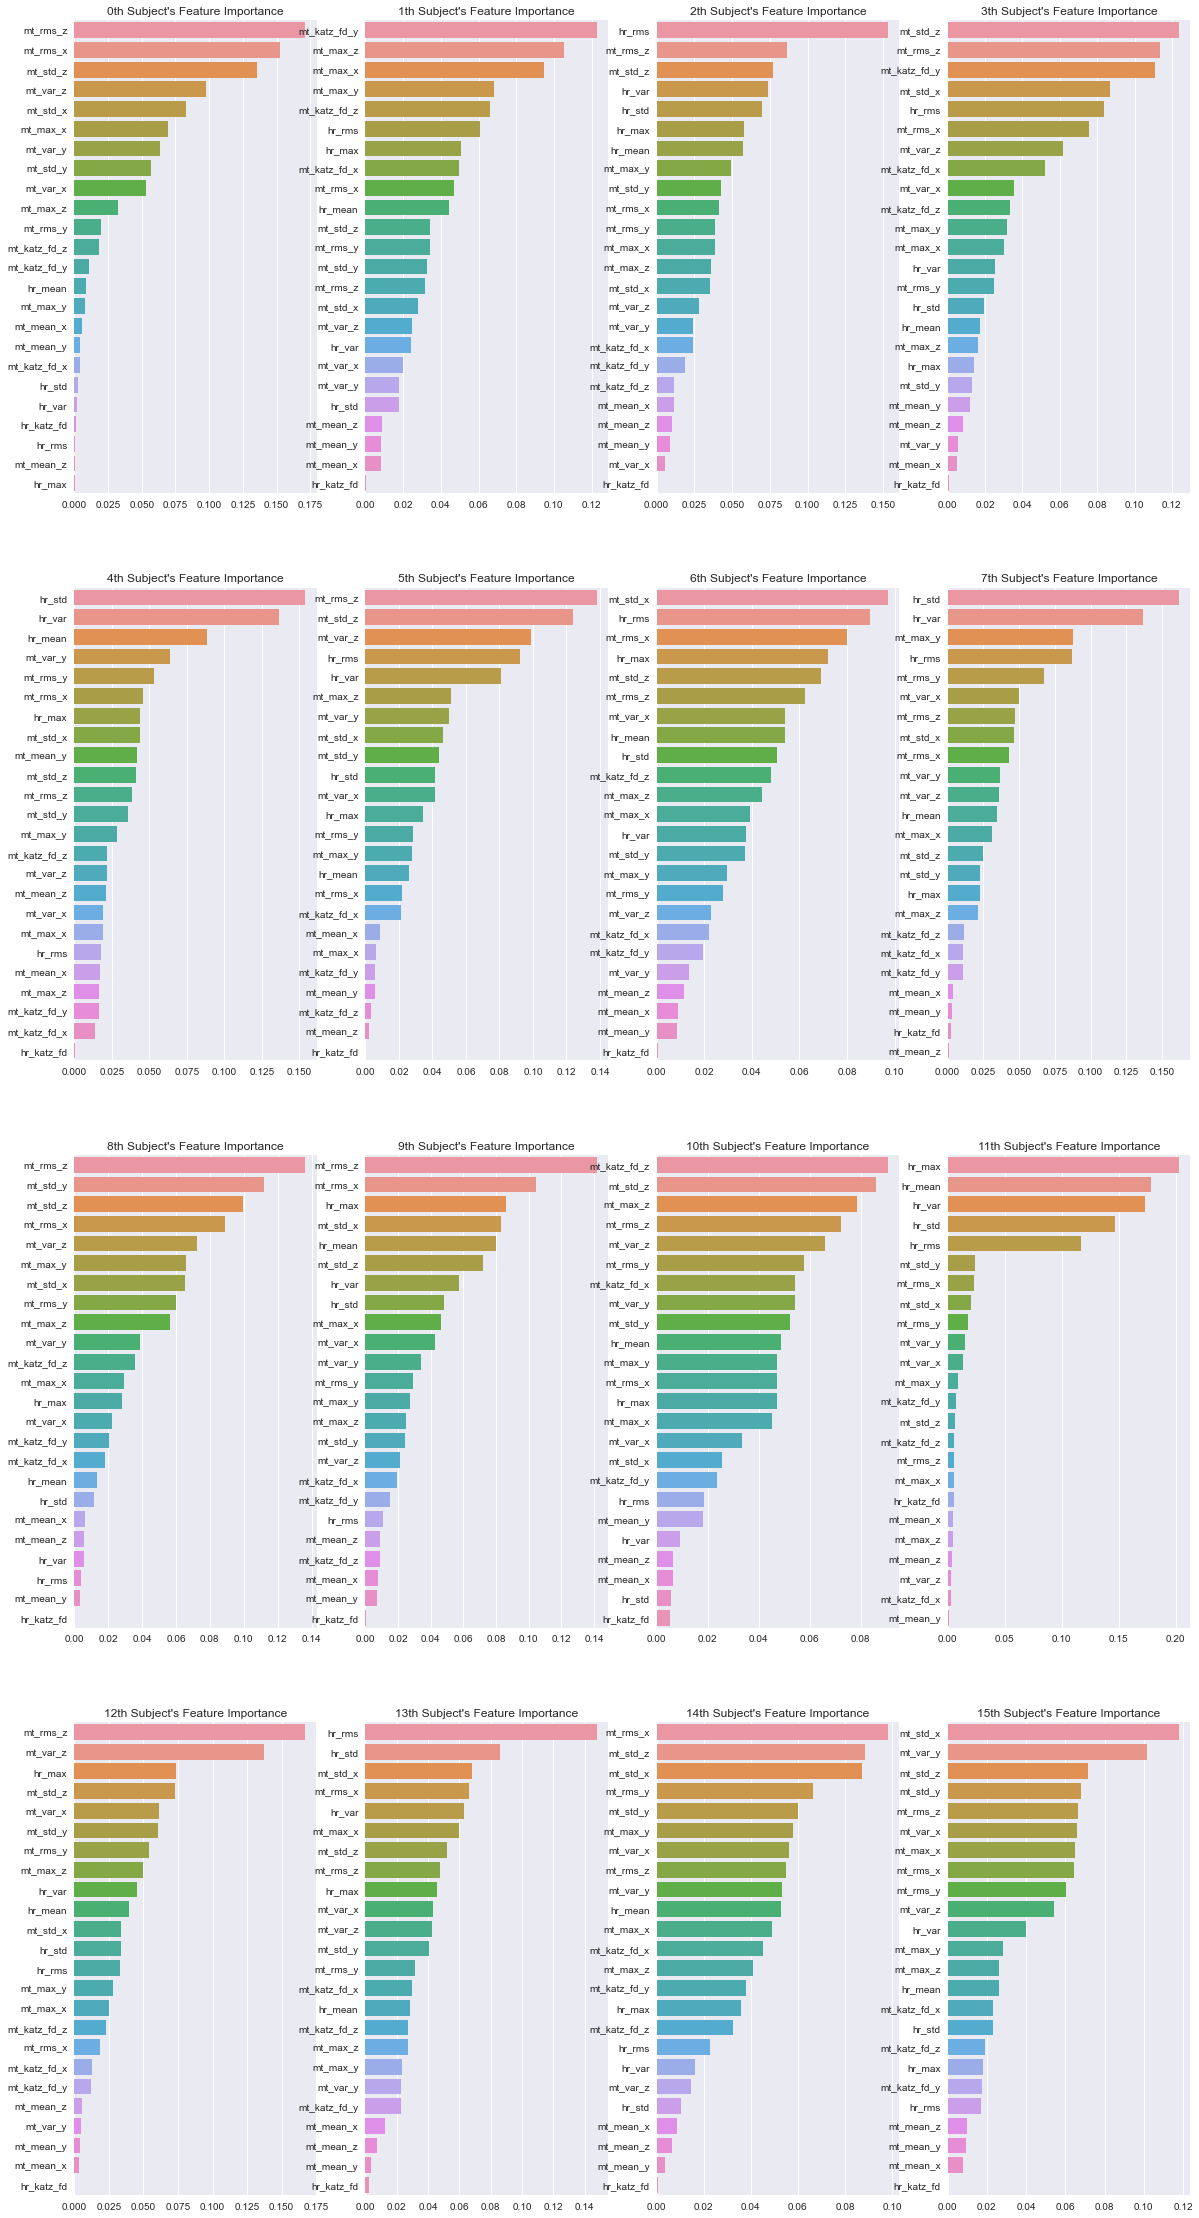

In [51]:
plot_ft_importance(wake_deep_feat_importance)

In [54]:
wake_deep_res = [0] * 16 # 16명 피험자의 Sleep VS Deep 분류 f1-score 리스트
wake_deep_ft_cnt = [-1] * 16  # 16명 피험자의 피쳐 개수 리스트


for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    
    # 수면 라벨링이 0, 3인 데이터만 추출
    df = df[(df['label'] ==  0) | (df['label'] ==  3)]
    
    # 피쳐 중요도 인덱스 추출
    ft_importance = wake_deep_feat_importance[i].index
    
    for j in tqdm(range(len(ft_importance))):
        
        # feature importance 가 높은 순서대로 1개씩 더해가며 피쳐 추가 후 성능 확인
        col = ft_importance[:j+1]
        
        tmp_df = df[col]
        
        # N3를 1로 치환
        tmp_df['label'] = df['label'].replace(3, 1)
        
        data, target = tmp_df.drop('label', axis=1), tmp_df['label']
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

        # 5-fold cv로 교차 검증 결과의 평균
        score = np.mean(cross_val_score(clf, data, target, scoring='f1', cv=5))
        
        
        # 현재 결과가 최댓값보다 크면 f1-score와 feature 개수 update
        if score > wake_deep_res[i]:
            wake_deep_res[i] = score
            wake_deep_ft_cnt[i] = j+1

    print(wake_deep_res[i], wake_deep_ft_cnt[i])

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

0.7784126984126984 3


  0%|          | 0/24 [00:00<?, ?it/s]

0.63608228980322 1


  0%|          | 0/24 [00:00<?, ?it/s]

0.8286905499041722 2


  0%|          | 0/24 [00:00<?, ?it/s]

0.9615301638893188 23


  0%|          | 0/24 [00:00<?, ?it/s]

0.9400422237860662 19


  0%|          | 0/24 [00:00<?, ?it/s]

0.9632493911310702 7


  0%|          | 0/24 [00:00<?, ?it/s]

0.7621921193598212 6


  0%|          | 0/24 [00:00<?, ?it/s]

0.900020325203252 9


  0%|          | 0/24 [00:00<?, ?it/s]

0.8782495623905977 7


  0%|          | 0/24 [00:00<?, ?it/s]

0.8582015909338564 21


  0%|          | 0/24 [00:00<?, ?it/s]

0.9439423735761764 4


  0%|          | 0/24 [00:00<?, ?it/s]

0.5785897608280753 5


  0%|          | 0/24 [00:00<?, ?it/s]

0.961620253164557 24


  0%|          | 0/24 [00:00<?, ?it/s]

0.9181658805290761 10


  0%|          | 0/24 [00:00<?, ?it/s]

0.8526876513317191 5


  0%|          | 0/24 [00:00<?, ?it/s]

0.9088288539767555 3


In [55]:
get_score_with_ft_cnt(wake_deep_res, wake_deep_ft_cnt)

0th f1-score: 0.77841, Feature Number: 3
1th f1-score: 0.63608, Feature Number: 1
2th f1-score: 0.82869, Feature Number: 2
3th f1-score: 0.96153, Feature Number: 23
4th f1-score: 0.94004, Feature Number: 19
5th f1-score: 0.96325, Feature Number: 7
6th f1-score: 0.76219, Feature Number: 6
7th f1-score: 0.90002, Feature Number: 9
8th f1-score: 0.87825, Feature Number: 7
9th f1-score: 0.85820, Feature Number: 21
10th f1-score: 0.94394, Feature Number: 4
11th f1-score: 0.57859, Feature Number: 5
12th f1-score: 0.96162, Feature Number: 24
13th f1-score: 0.91817, Feature Number: 10
14th f1-score: 0.85269, Feature Number: 5
15th f1-score: 0.90883, Feature Number: 3


# 4-class classification

4-class 분류 결과 cross validation 시 macro f1-score가 대부분 0.5를 넘지 못했다.

이는 Light의 데이터가 다른 데이터에 비해 많아 Data Imbalanced 문제를 일으킨 것으로 예상된다.

In [58]:
# WAKE = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5
# Wake = 0, Light = 1, Deep = 2 ,REM = 3

sleep_stage = [] # 수면 단계 분류 결과 리스트 

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    tmp_df = df.copy() # 원본 데이터 복사
    
    # Light(N1+N2)를 위해 수면 라벨링 2를 1로 치환
    tmp_df['label'].replace(2, 1, inplace=True)

    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target)
    
    # F1 스코어를 사용하는 scoring 함수 생성 (다중 분류를 위해)
    scoring = make_scorer(f1_score, average='macro')
    
    clf = RandomForestClassifier() # 랜덤 포레스트 모델
    
    # 5-fold cv로 교차 검증 결과의 평균
    score = np.mean(cross_val_score(clf, data, target, scoring=scoring, cv=5))
    
    sleep_stage.append(score)

# 넘파이 배열로 변환
sleep_stage = np.array(sleep_stage)


  0%|          | 0/16 [00:00<?, ?it/s]

In [64]:
# 결과 출력
for i in range(len(sleep_stage)):
    print(f'{i}th 피험자 4-class 수면 분류 f1-score : {sleep_stage[i]:.5f}')

print('============================================================')
print(f'평균 f1-score : {np.mean(sleep_stage):.5f}')

0th 피험자 4-class 수면 분류 f1-score : 0.39806
1th 피험자 4-class 수면 분류 f1-score : 0.37676
2th 피험자 4-class 수면 분류 f1-score : 0.39635
3th 피험자 4-class 수면 분류 f1-score : 0.53273
4th 피험자 4-class 수면 분류 f1-score : 0.59844
5th 피험자 4-class 수면 분류 f1-score : 0.47912
6th 피험자 4-class 수면 분류 f1-score : 0.53249
7th 피험자 4-class 수면 분류 f1-score : 0.43514
8th 피험자 4-class 수면 분류 f1-score : 0.50435
9th 피험자 4-class 수면 분류 f1-score : 0.49847
10th 피험자 4-class 수면 분류 f1-score : 0.38983
11th 피험자 4-class 수면 분류 f1-score : 0.31465
12th 피험자 4-class 수면 분류 f1-score : 0.51602
13th 피험자 4-class 수면 분류 f1-score : 0.52902
14th 피험자 4-class 수면 분류 f1-score : 0.45227
15th 피험자 4-class 수면 분류 f1-score : 0.47052
평균 f1-score : 0.46401


In [65]:
stage_feat_importance = []

for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    tmp_df = df.copy()
    
    # Light(N1+N2)를 위해 수면 라벨링 2를 1로 치환
    tmp_df['label'].replace(2, 1, inplace=True)
    
    data, target = tmp_df.drop('label', axis=1), tmp_df['label']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)
    
    clf = RandomForestClassifier() # 랜덤 포레스트 모델 사용
    clf.fit(X_train, y_train) # 모델 학습

    # 피처 중요도 얻기
    feature_importance = clf.feature_importances_
    
    # 시리즈로 변환 후 내림차순 정렬
    ft_series = pd.Series(feature_importance, index = X_train.columns).sort_values(ascending=False)
    
    # 리스트에 추가
    stage_feat_importance.append(ft_series)


  0%|          | 0/16 [00:00<?, ?it/s]

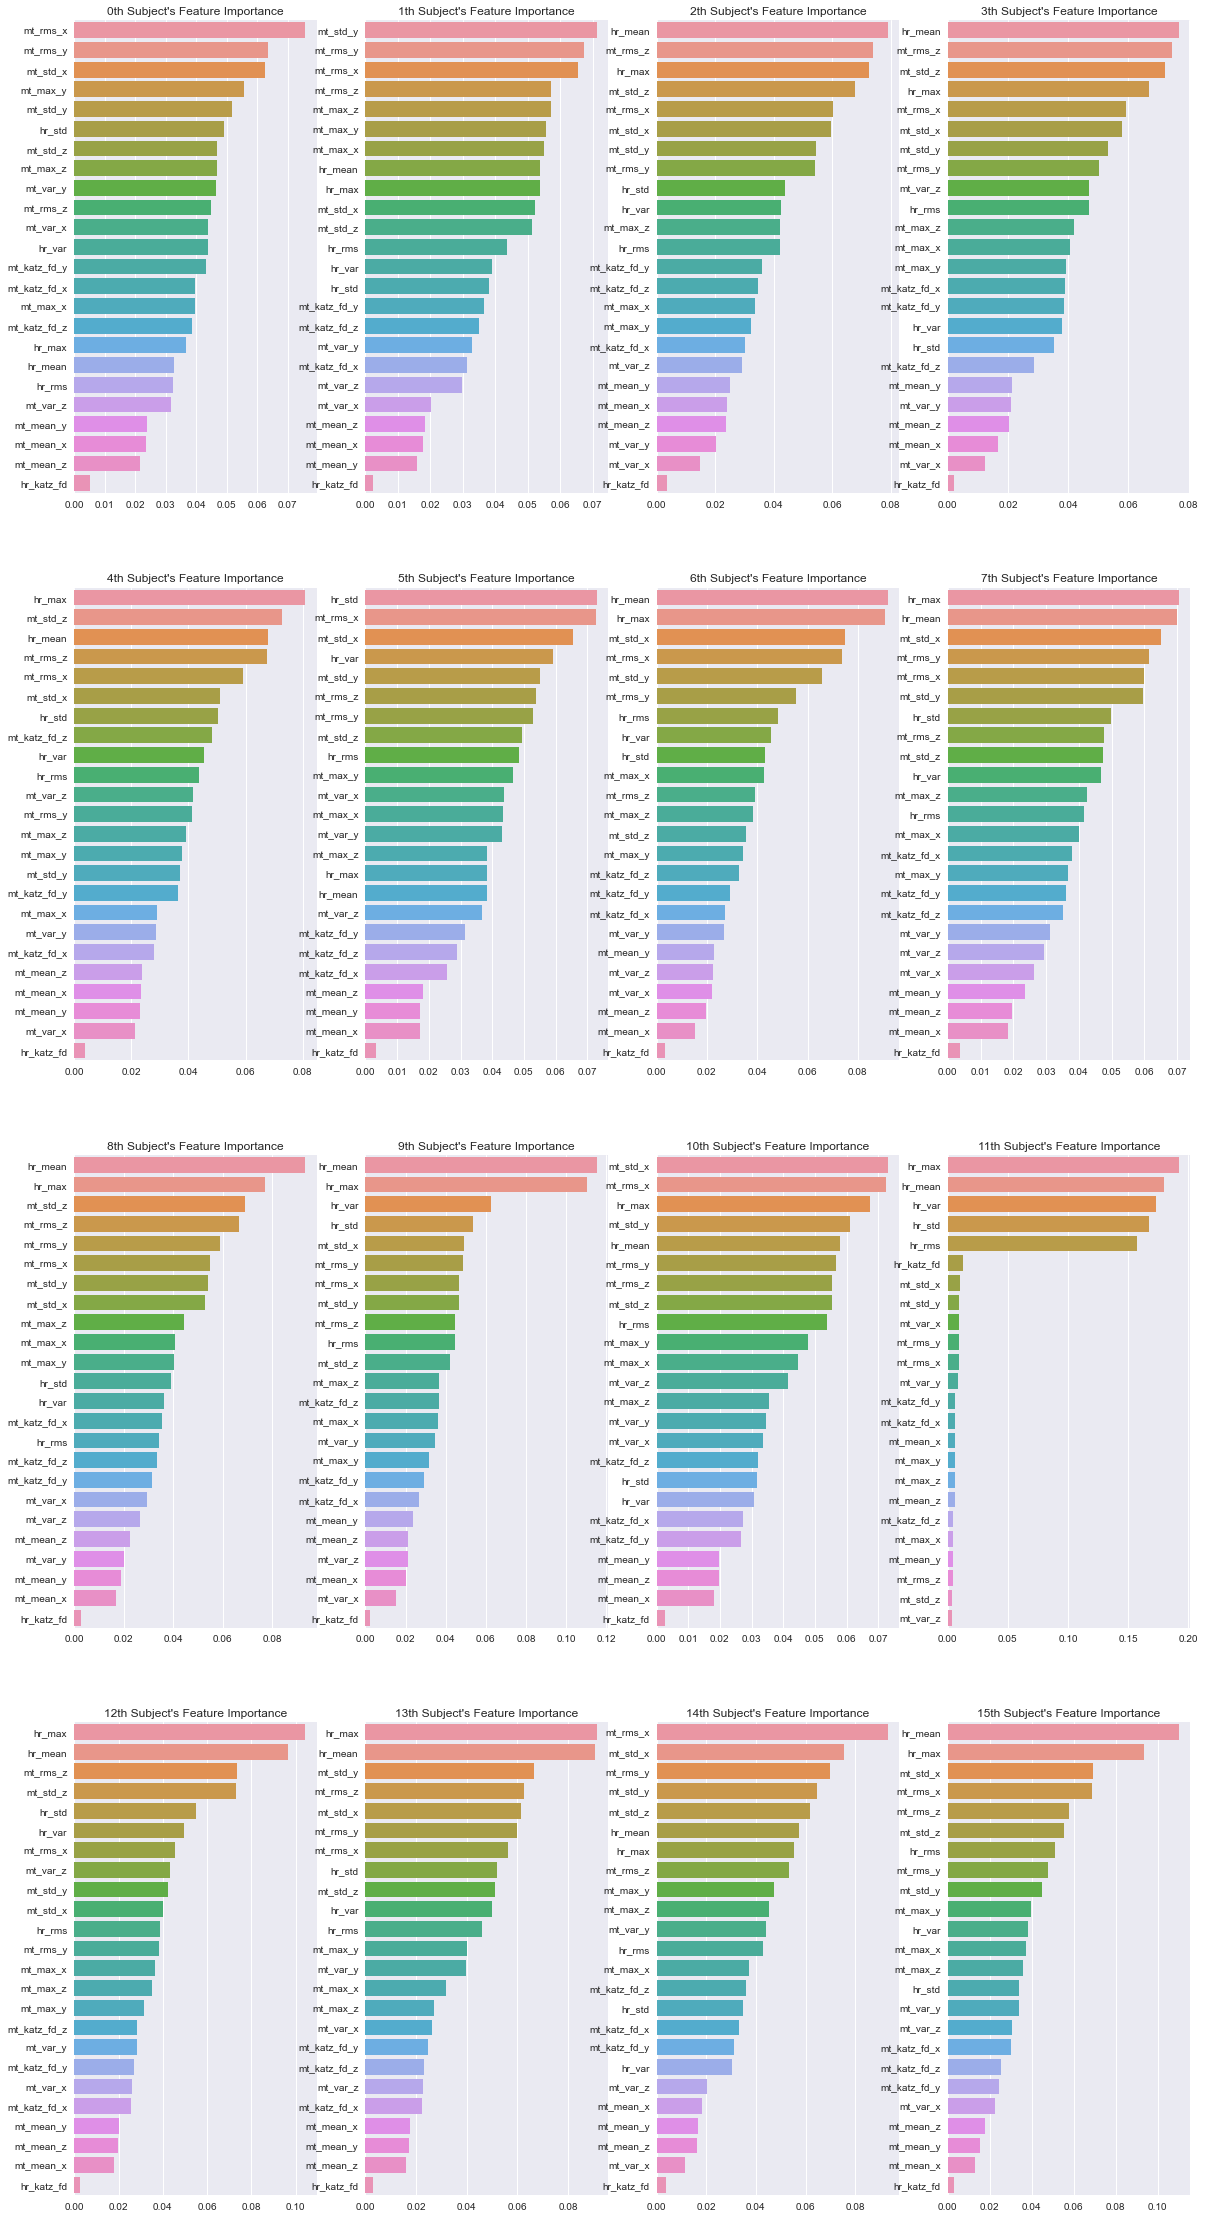

In [66]:
plot_ft_importance(stage_feat_importance)

In [67]:
sleep_stage_res = [0] * 16 # 16명 피험자의 4-class 수면 단계 분류 macro f1-score 리스트
sleep_stage_ft_cnt = [-1] * 16 # 16명 피험자의 피쳐 개수 리스트
sleep_stage_confusion_matrix = [[]] * 16 # 16명 피험자의 수면 분류 confusion matrix


for i in tqdm(range(len(sleep_df))):
    df = sleep_df[i]
    tmp_df = df.copy()
    
    # Light(N1+N2)를 위해 수면 라벨링 2를 1로 치환
    tmp_df['label'].replace(2, 1, inplace=True)
    
    # 피쳐 중요도 인덱스 추출
    ft_importance = stage_feat_importance[i].index
    
    for j in tqdm(range(len(ft_importance))):
        
        # feature importance 가 높은 순서대로 1개씩 더해가며 피쳐 추가 후 성능 확인
        col = ft_importance[:j+1]
        data, target = tmp_df.drop('label', axis=1), tmp_df['label']
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target)
        clf = RandomForestClassifier()
        
        # F1 스코어를 사용하는 scoring 함수 생성 (다중 분류를 위해)
        scoring = make_scorer(f1_score, average='macro')
        
        # 5-fold cv로 교차 검증 결과의 평균
        cv_scores = cross_val_score(clf, X_train, y_train, scoring=scoring, cv=5) 
        
        clf.fit(X_train, y_train)
        
        pred = clf.predict(X_test)
        score = f1_score(y_test, pred, average='macro')  # 'macro' 평균 사용
        mat = confusion_matrix(y_test, pred) # confusion matrix

        # 현재 결과가 최댓값보다 크면 f1-score와 feature 개수 update
        if score > sleep_stage_res[i]:
            sleep_stage_res[i] = score
            sleep_stage_ft_cnt[i] = j+1
            sleep_stage_confusion_matrix[i] = mat

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [68]:
get_score_with_ft_cnt(sleep_stage_res, sleep_stage_ft_cnt)

0th f1-score: 0.73676, Feature Number: 5
1th f1-score: 0.82082, Feature Number: 22
2th f1-score: 0.77775, Feature Number: 20
3th f1-score: 0.85859, Feature Number: 6
4th f1-score: 0.78971, Feature Number: 6
5th f1-score: 0.82326, Feature Number: 8
6th f1-score: 0.82842, Feature Number: 4
7th f1-score: 0.82458, Feature Number: 11
8th f1-score: 0.77497, Feature Number: 20
9th f1-score: 0.77800, Feature Number: 13
10th f1-score: 0.79132, Feature Number: 13
11th f1-score: 0.60976, Feature Number: 24
12th f1-score: 0.82103, Feature Number: 17
13th f1-score: 0.80320, Feature Number: 12
14th f1-score: 0.83777, Feature Number: 14
15th f1-score: 0.88018, Feature Number: 15


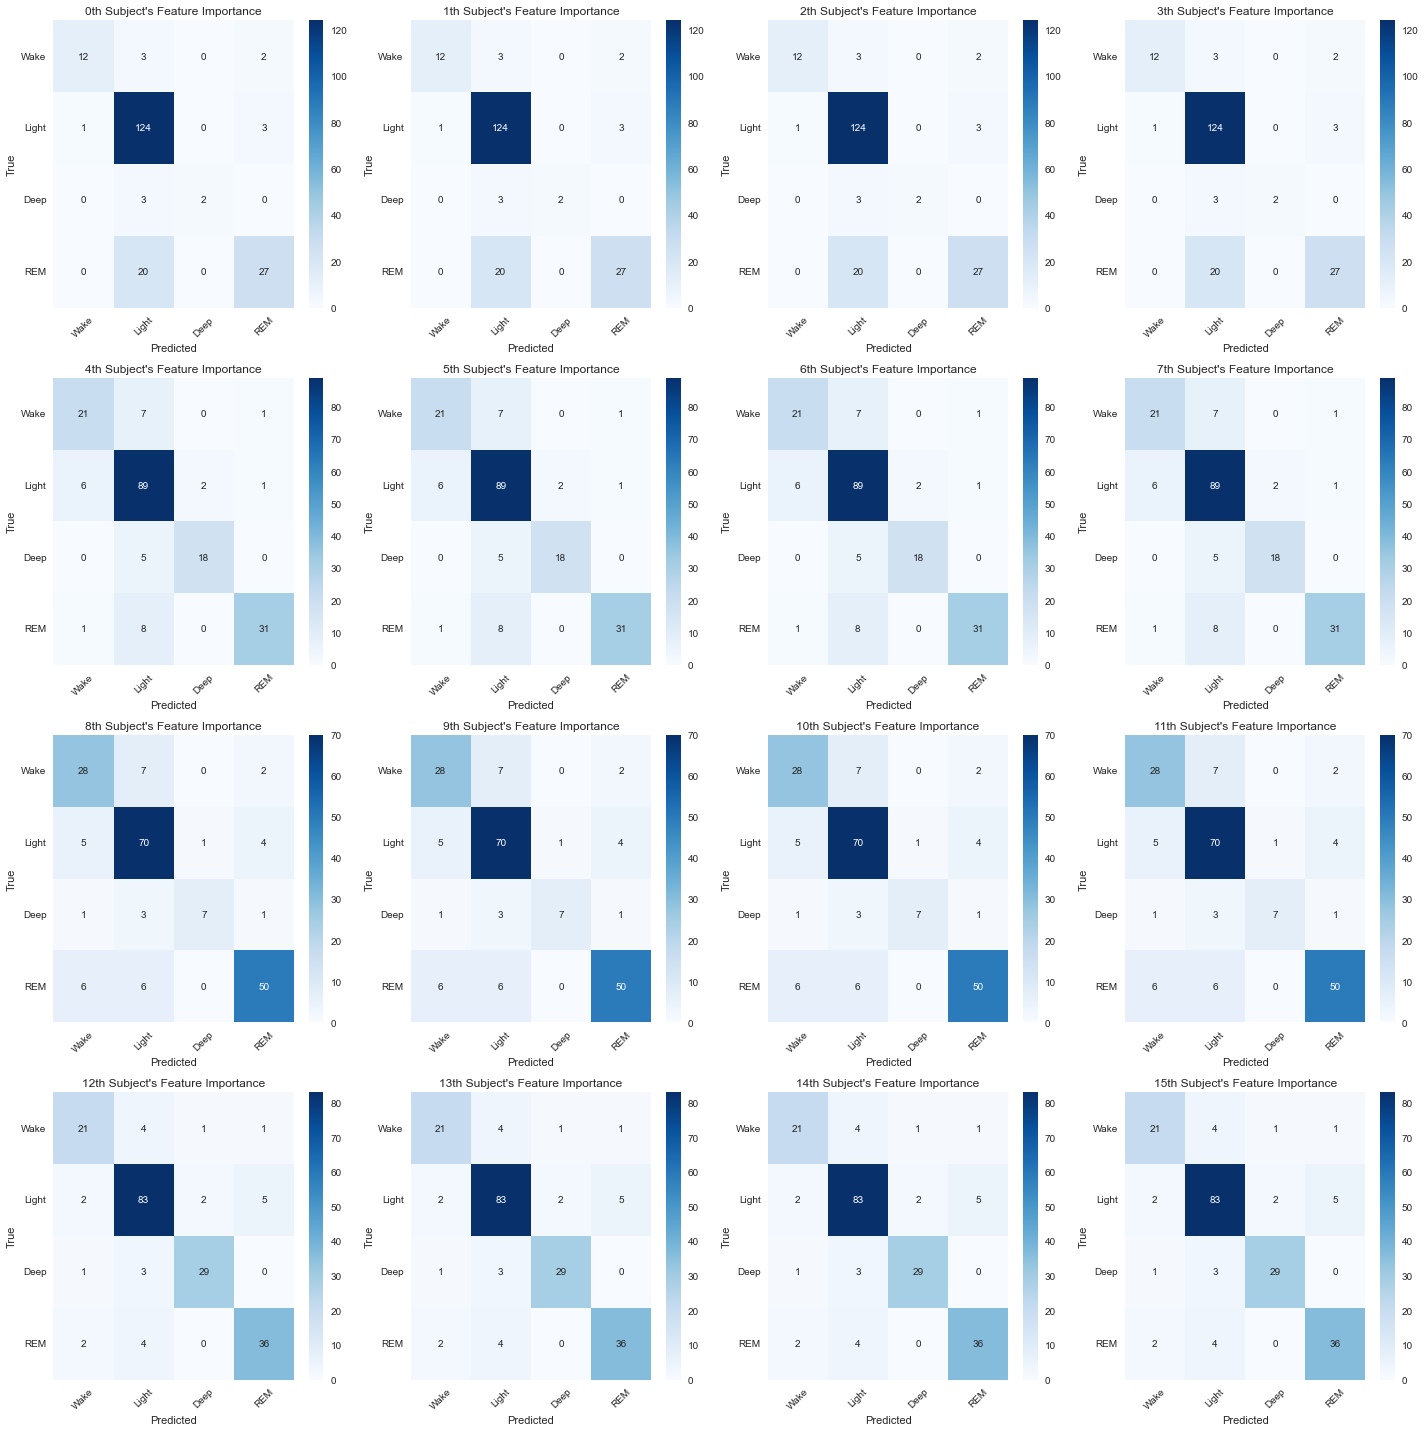

In [83]:
# 레이블 클래스 이름 설정
class_names = ['Wake', 'Light', 'Deep', 'REM']

f, axes = plt.subplots(4, 4, figsize=(20, 20))

# confusion matrix visualization
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        
        sns.heatmap(sleep_stage_confusion_matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax)
        
        ax.set_xticklabels(class_names, rotation=45)
        ax.set_yticklabels(class_names, rotation=0)
        
        ax.set_title(f"{i*4+j}th Subject's Feature Importance")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        
plt.tight_layout()
plt.show()

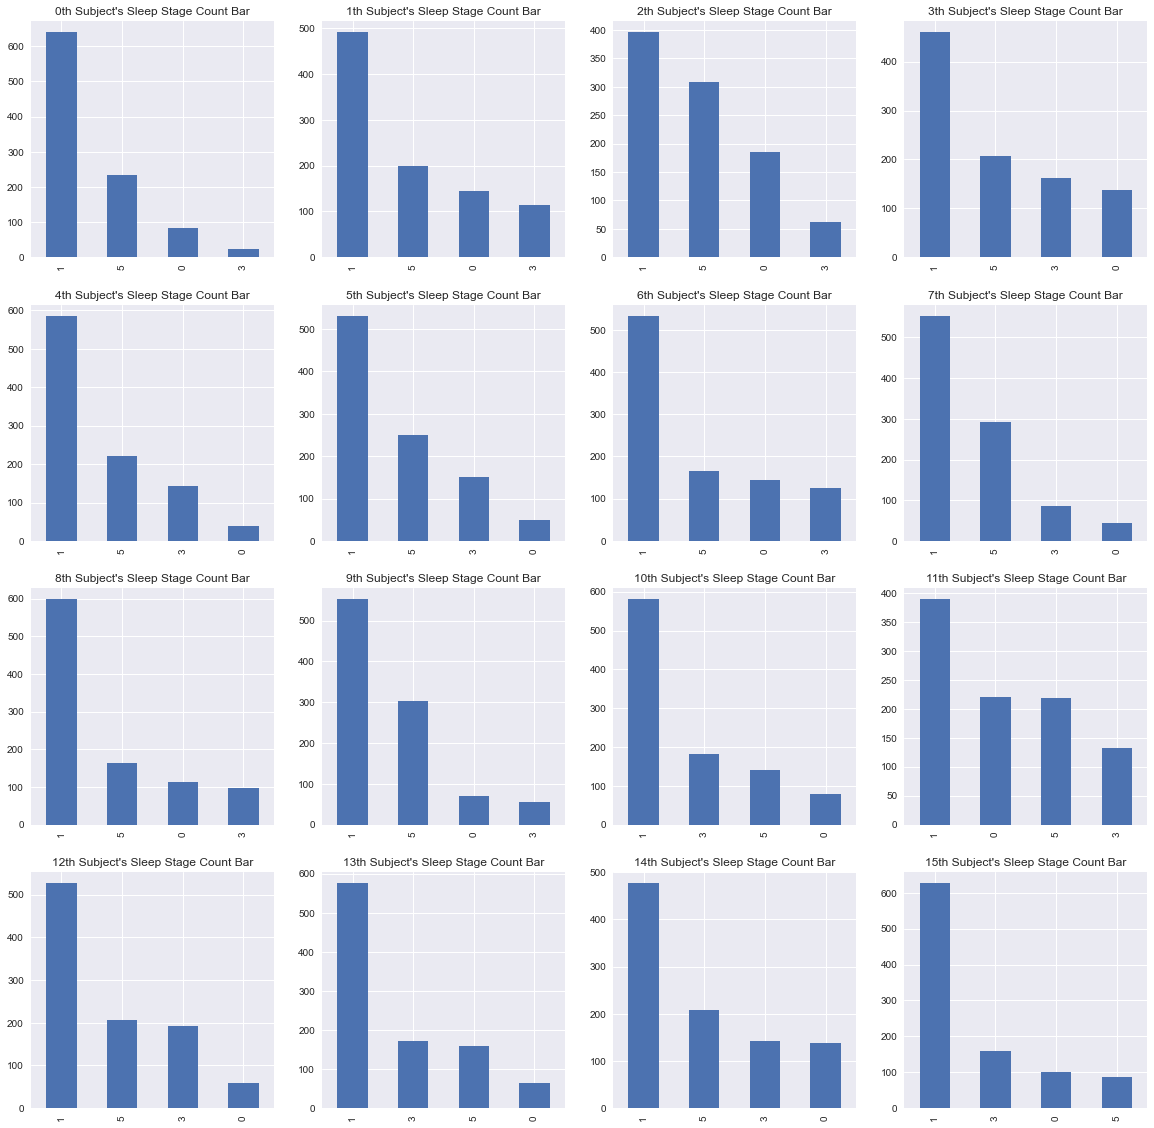

In [84]:
f, axes = plt.subplots(4, 4, figsize=(20, 20))

# Sleep Stage Count Bar 출력 (Light 단계가 다른 수면 단계에 비해 압도적으로 많음)
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        df = sleep_df[i*4 + j]
        
        tmp_df = df.copy()
        
        # Light(N1+N2)를 위해 수면 라벨링 2를 1로 치환
        tmp_df.replace(2, 1, inplace=True)
        tmp_df['label'].value_counts().plot.bar(ax=ax)        
        
        ax.set_title(f"{i*4+j}th Subject's Sleep Stage Count Bar")